# Session 13

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [32]:
# ! git config --global user.email "me18b059@smail.iitm.ac.in"
# ! git stash push --include-untracked
# ! git stash drop
# ! git pull

Saved working directory and index state WIP on master: 8ddcdf0 commit
Dropped refs/stash@{0} (85d0f02c3fd0c0a866918ed1aad9a7699ad43b20)
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), 525 bytes | 9.00 KiB/s, done.
From https://github.com/Madhur-1/ERA-v1
   8ddcdf0..3fda962  master     -> origin/master
Updating 8ddcdf0..3fda962
Fast-forward
 S13/Utilities/config.py | 4 ++--
 S13/Utilities/model.py  | 2 +-
 2 files changed, 3 insertions(+), 3 deletions(-)


In [3]:
%cd S13/

/content/drive/MyDrive/Github/ERA-v1/S13


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [4]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install pytorch_lightning

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# del model

from Utilities.model import YOLOv3
from torchsummary import summary
from Utilities import config

# Model Initialization & Summary

In [7]:
model = YOLOv3(num_classes=config.NUM_CLASSES)

summary(model.to(config.DEVICE), input_size=(3, config.IMAGE_SIZE, config.IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          CNNBlock-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          CNNBlock-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         CNNBlock-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

# Dataset & Dataloaders

In [8]:
from Utilities.dataset import YOLODataModule

data_module = YOLODataModule(train_csv_path=config.DATASET + '/train.csv',
                             test_csv_path=config.DATASET + "/test.csv")

# Training

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from Utilities.callbacks import PlotTestExamplesCallback, MAPCallback, CheckClassAccuracyCallback

trainer = pl.Trainer(
    max_epochs=40,
    accelerator=config.DEVICE,
    callbacks=[
        ModelCheckpoint(
            dirpath=config.CHECKPOINT_PATH,
            verbose=True,
        ),
        PlotTestExamplesCallback(every_n_epochs=3),
        CheckClassAccuracyCallback(train_every_n_epochs=1, test_every_n_epochs=3),
        MAPCallback(every_n_epochs=40),
        LearningRateMonitor(logging_interval='step', log_momentum=True),
    ],
    default_root_dir='Store/',
    precision=16,
)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [10]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,datamodule=data_module, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/drive/MyDrive/Github/ERA-v1/S13/Store/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


EPOCH: 0, Loss: 99.85496520996094


INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 34 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0031622776601683794
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at Store/.lr_find_17d72e9f-559e-4db5-a3d1-1b6a38570885.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at Store/.lr_find_17d72e9f-559e-4db5-a3d1-1b6a38570885.ckpt


new_lr=0.0031622776601683794


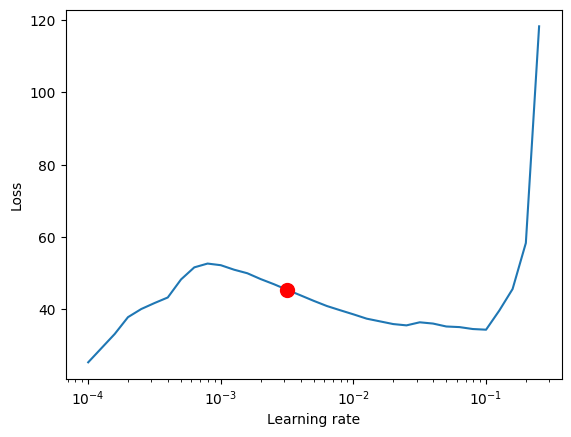

In [11]:
# Results can be found in
# print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [12]:
model.best_lr = 0.0031622776601683794

# Testing & Evaluation

1. Add on_train_end -> torch.save
2. Print LR
3. Check ERA conditions

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/drive/MyDrive/Github/ERA-v1/S13/Store/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 61.6 M
--------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
246.506   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


+++ TRAIN ACCURACIES



100%|██████████| 414/414 [11:02<00:00,  1.60s/it]


Class accuracy is: 33.420132%
No obj accuracy is: 99.903259%
Obj accuracy is: 0.152415%
EPOCH: 0, Loss: 18.645620346069336
+++ TRAIN ACCURACIES



100%|██████████| 414/414 [11:07<00:00,  1.61s/it]


Class accuracy is: 35.920795%
No obj accuracy is: 99.978851%
Obj accuracy is: 0.360452%
EPOCH: 1, Loss: 12.616435050964355


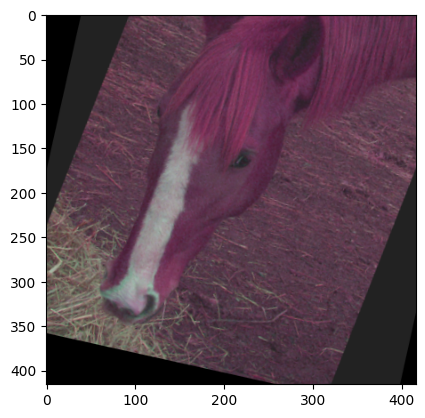

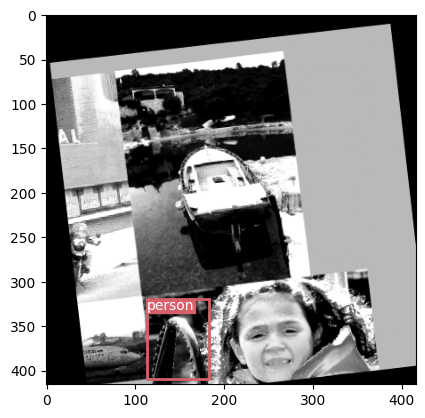

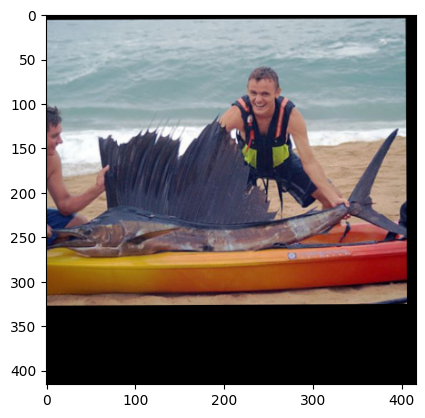

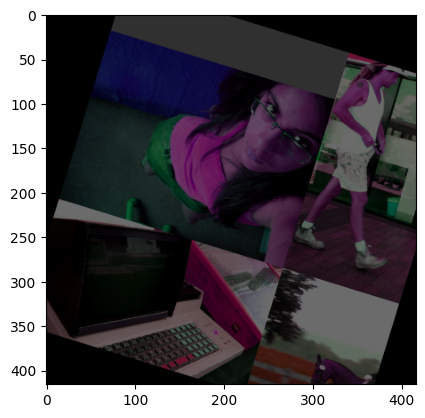

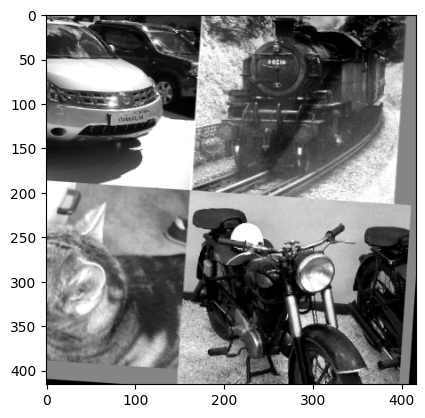

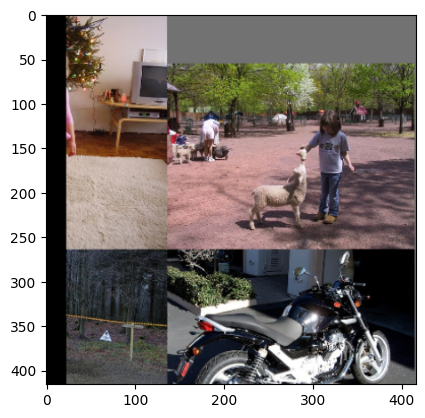

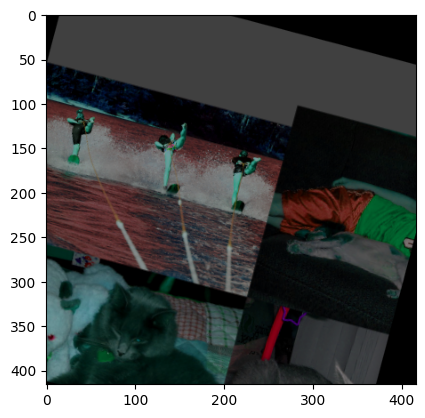

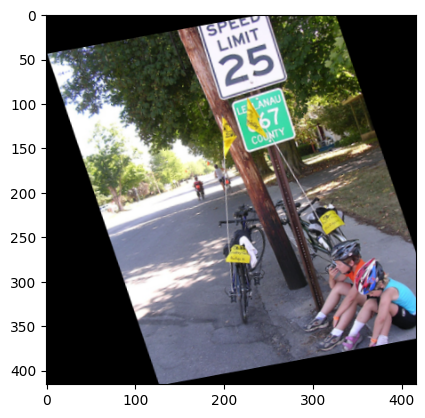

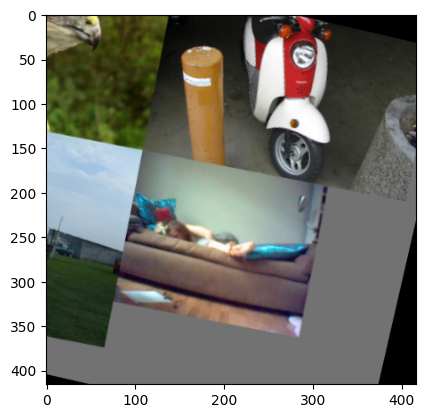

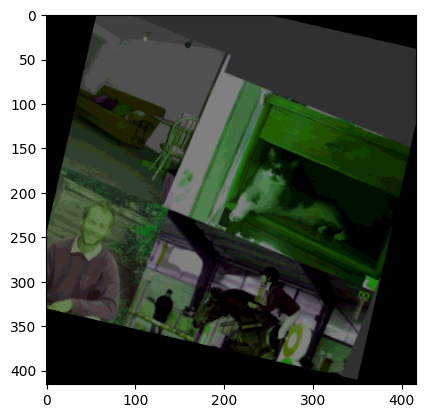

+++ TRAIN ACCURACIES



100%|██████████| 414/414 [11:12<00:00,  1.62s/it]


Class accuracy is: 28.949404%
No obj accuracy is: 98.724480%
Obj accuracy is: 17.628134%
+++ TEST ACCURACIES



100%|██████████| 124/124 [24:35<00:00, 11.90s/it]


Class accuracy is: 35.477974%
No obj accuracy is: 99.171776%
Obj accuracy is: 12.080909%
EPOCH: 2, Loss: 11.338910102844238
+++ TRAIN ACCURACIES



100%|██████████| 414/414 [11:24<00:00,  1.65s/it]


Class accuracy is: 41.440239%
No obj accuracy is: 96.176926%
Obj accuracy is: 43.857906%
EPOCH: 3, Loss: 10.507396697998047
+++ TRAIN ACCURACIES



100%|██████████| 414/414 [11:13<00:00,  1.63s/it]


Class accuracy is: 37.159164%
No obj accuracy is: 94.881592%
Obj accuracy is: 57.167423%
EPOCH: 4, Loss: 9.860551834106445


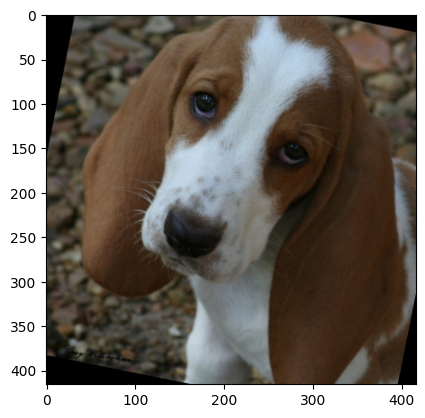

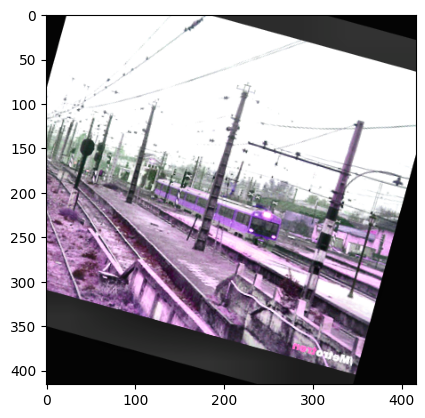

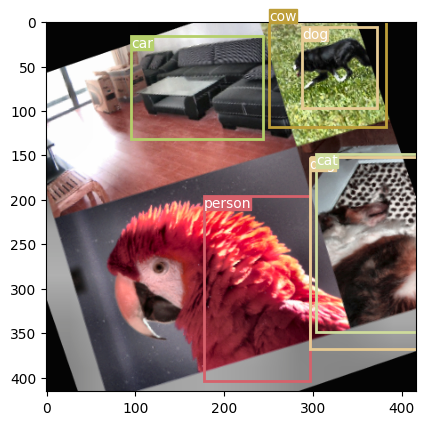

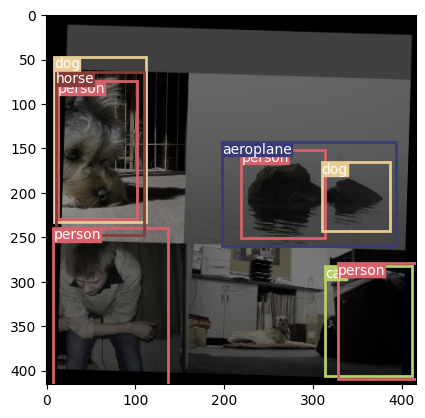

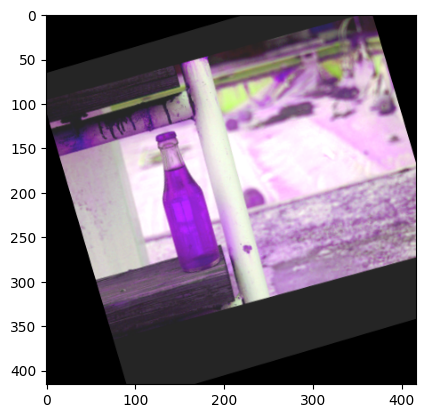

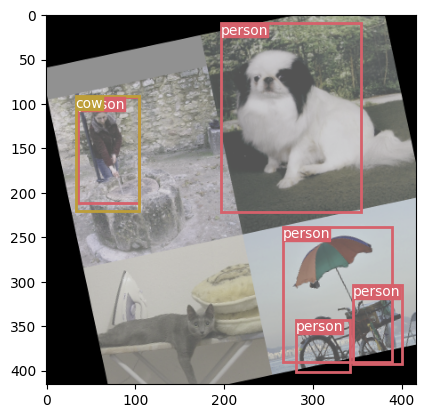

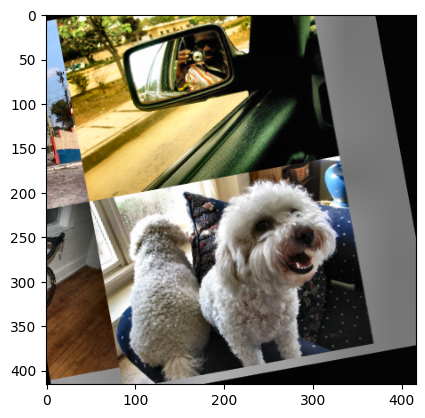

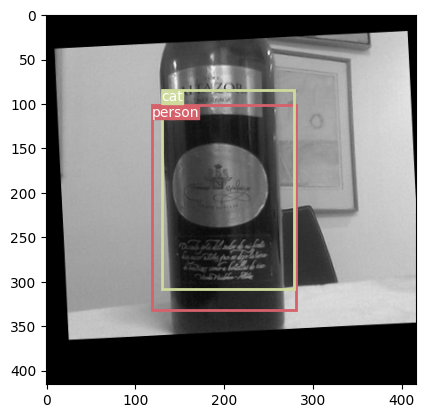

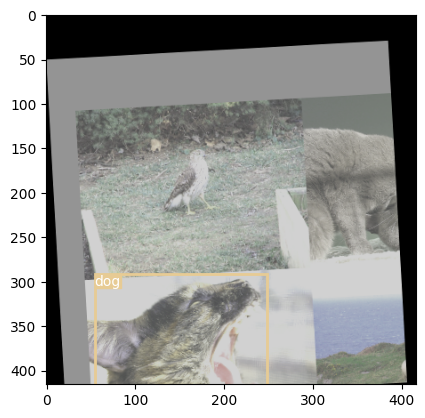

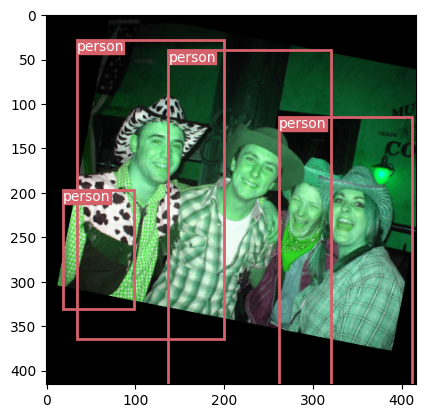

+++ TRAIN ACCURACIES



 17%|█▋        | 71/414 [01:58<08:59,  1.57s/it]

100%|██████████| 414/414 [11:26<00:00,  1.66s/it]


Class accuracy is: 45.707317%
No obj accuracy is: 96.149239%
Obj accuracy is: 56.684910%
+++ TEST ACCURACIES



100%|██████████| 124/124 [01:40<00:00,  1.24it/s]


Class accuracy is: 56.744247%
No obj accuracy is: 97.352829%
Obj accuracy is: 48.800220%
EPOCH: 5, Loss: 9.31708812713623


FailedPreconditionError: ignored

In [13]:
trainer.fit(model=model, datamodule=data_module)

In [14]:
trainer.fit(model, data_module, ckpt_path=config.CHECKPOINT_PATH)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


OSError: ignored

### Git Push

In [ ]:
! git remote set-url origin git@github.com:Madhur-1/ERA-v1.git
! git add .
# ! git commit -m "S12 commit 92.31%"
! git push

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
